# Lane Lines

## Import Packages

In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Helper Functions

In [85]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Read Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


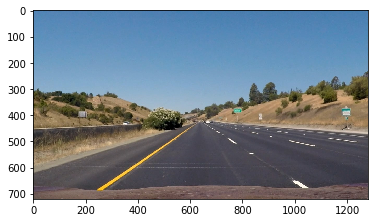

In [86]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image.squeeze())
plt.show()

## Simple Laning

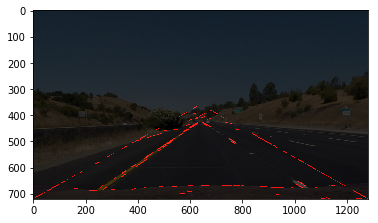

In [265]:
def simple_process_img(orig):
    res = grayscale(orig)
    res = gaussian_blur(res, 5)
    res = region_of_interest(res, np.array([[
        [0, orig.shape[0]],
        [orig.shape[1], orig.shape[0]],
        [orig.shape[1] // 2, orig.shape[0] // 2],
    ]]))
    res = canny(res, 50, 100)
    res = hough_lines(res, 1, np.pi / 180, 1, 10, 1)
    res = weighted_img(res, orig, α=0.25, β=10.)
    return res


plt.imshow(simple_process_img(image).squeeze())
plt.show()

## Distortion Correction

Ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

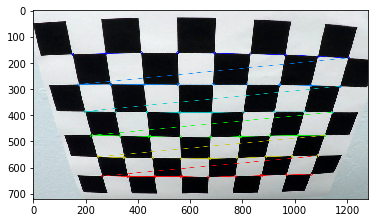

In [91]:
def distortion_correction_prep(seed, to_draw=None):
    w, h = 9, 6

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((w * h, 3), np.float32)
    objp[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    images = glob.glob(seed)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            if fname == to_draw:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (w, h), corners2, ret)
                plt.imshow(img.squeeze())
                plt.show()

    cv2.destroyAllWindows()

    return(objpoints, imgpoints)


objpoints, imgpoints = distortion_correction_prep("camera_cal/*.jpg", "camera_cal/calibration2.jpg")

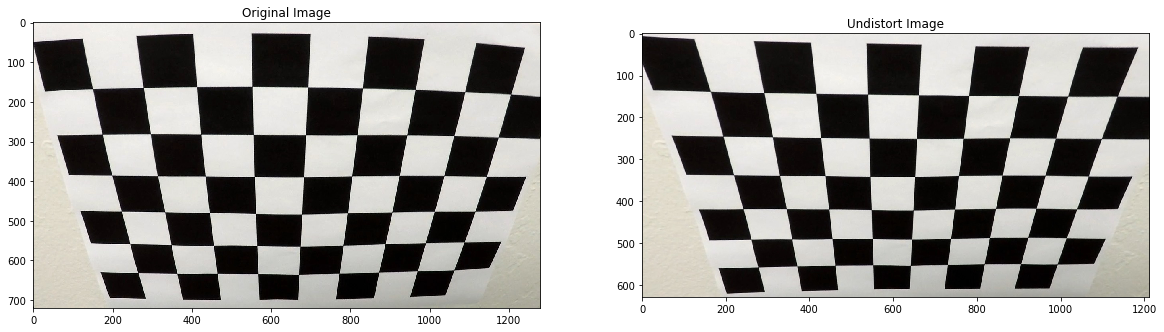

In [107]:
def undistort(img, objpoints, imgpoints):
    # calibrate camera
    h, w = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x, y, w, h = roi
    dst = dst[y:y + h, x:x + w]

    return dst


fig, axs = plt.subplots(1, 2, figsize=(20, 30))
chess = mpimg.imread("camera_cal/calibration2.jpg")
axs[0].imshow(chess)
axs[0].set_title("Original Image")
axs[1].imshow(undistort(chess, objpoints, imgpoints))
axs[1].set_title("Undistort Image")
plt.show()

## Bird Eye View (Perspective Transform)

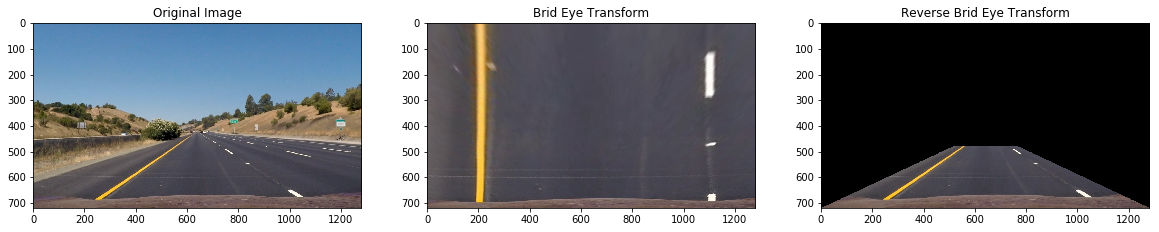

In [52]:
def get_bird_eye_transform_matrices(img):
    src = np.float32([
        [0, img.shape[0]],
        [img.shape[1], img.shape[0]],
        [3 * img.shape[1] // 5, 2 * img.shape[0] // 3],
        [2 * img.shape[1] // 5, 2 * img.shape[0] // 3],
    ])

    dst = np.float32([
        [0, img.shape[0]],
        [img.shape[1], img.shape[0]],
        [img.shape[1], 0],
        [0, 0],
    ])

    return cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)


def bird_eye(image, matrix):
    return cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)


def reverse_bird_eye(image, matrix):
    return cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)


test_image = image
bird_eye_transform, reverse_bird_eye_transform = get_bird_eye_transform_matrices(image)
transform_image = bird_eye(test_image, bird_eye_transform)

fig, axs = plt.subplots(1, 3, figsize=(20, 30))
axs[0].imshow(test_image.squeeze())
axs[0].set_title("Original Image")
axs[1].imshow(transform_image.squeeze())
axs[1].set_title("Brid Eye Transform")
axs[2].imshow(reverse_bird_eye(transform_image, reverse_bird_eye_transform).squeeze())
axs[2].set_title("Reverse Brid Eye Transform")
plt.show()

## Sobel Transform

Ref: http://opencvexamples.blogspot.com/2013/10/sobel-edge-detection.html  
Ref (Java): https://www.tutorialspoint.com/opencv/opencv_sobel_operator.htm

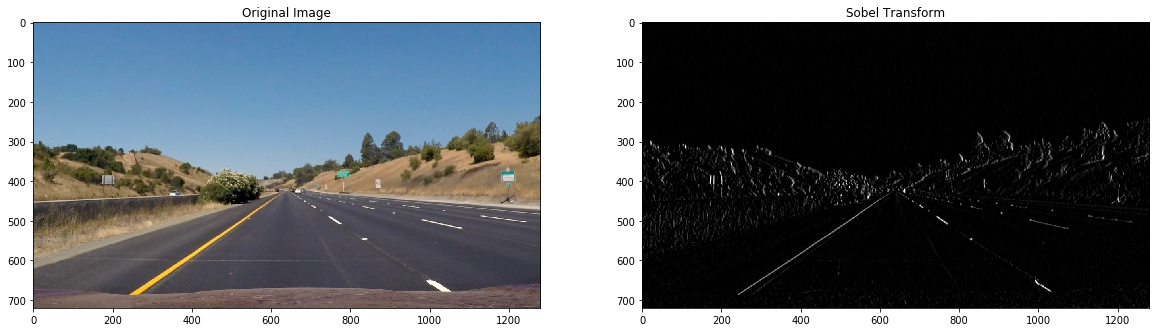

In [185]:
def sobel_transform(img):
    return cv2.Sobel(img, -1, 1, 0, ksize=3)


fig, axs = plt.subplots(1, 2, figsize=(20, 30))
axs[0].imshow(test_image.squeeze())
axs[0].set_title("Original Image")
axs[1].imshow(sobel_transform(grayscale(gaussian_blur(image, 5))).squeeze(), cmap="gray")
axs[1].set_title("Sobel Transform")
plt.show()

## Color Transform

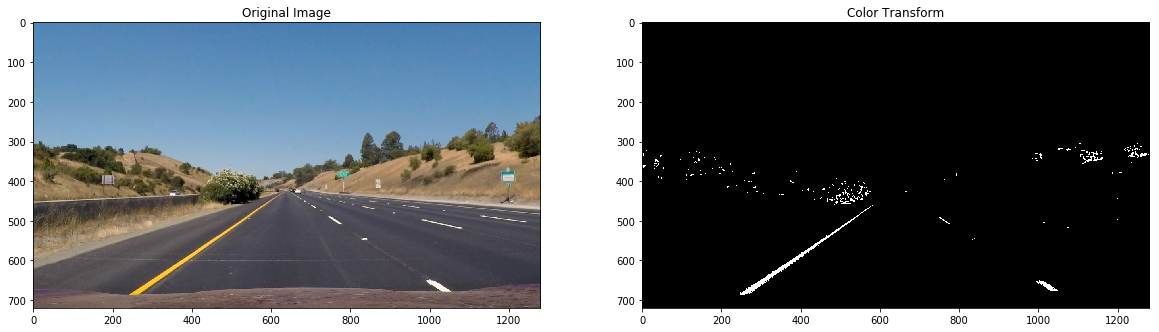

In [207]:
def color_transform(img, thresh=(160, 255)):
    return np.array([np.array([255 if thresh[0] <= point <= thresh[1] else 0 for point in row], dtype=np.uint8)
                               for row in cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]])


fig, axs = plt.subplots(1, 2, figsize=(20, 30))
axs[0].imshow(image.squeeze())
axs[0].set_title("Original Image")
axs[1].imshow(color_transform(image), cmap='gray')
axs[1].set_title("Color Transform")
plt.show()

## Laning

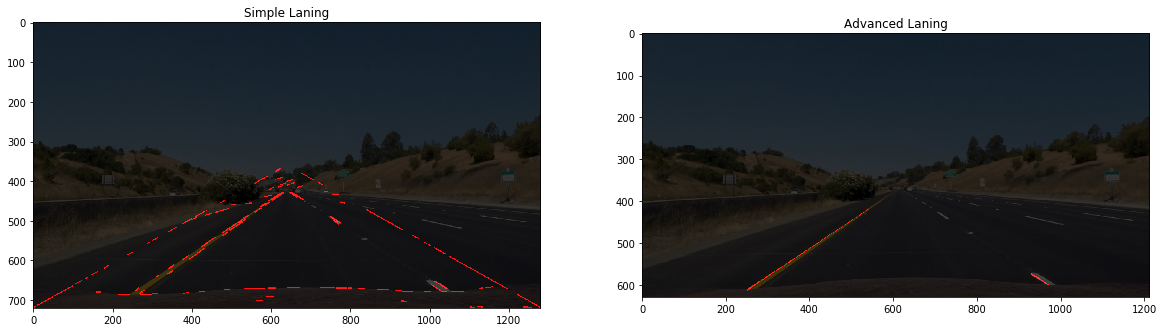

In [266]:
def process_img(orig):
    undistorted = undistort(orig, objpoints, imgpoints)
    prep = gaussian_blur(undistorted, 5)
    bird_eye_transform, reverse_bird_eye_transform = get_bird_eye_transform_matrices(prep)
    bird_eye_transformed = bird_eye(prep, bird_eye_transform)
    color_transformed = color_transform(bird_eye_transformed)
    sobel_transformed = sobel_transform(color_transformed)
#     canny_transformed = canny(sobel_transformed, 50, 100)
    heat_map = hough_lines(sobel_transformed, 1, np.pi / 180, 1, 1, 1)
    reverse_bird_eye_transformed = reverse_bird_eye(heat_map, reverse_bird_eye_transform)
    res = weighted_img(reverse_bird_eye_transformed, undistorted, α=0.25, β=10.)
    return res


fig, axs = plt.subplots(1, 2, figsize=(20, 30))
axs[0].imshow(simple_process_img(image).squeeze())
axs[0].set_title("Simple Laning")
axs[1].imshow(process_img(image), cmap='gray')
axs[1].set_title("Advanced Laning")
plt.show()

## Mass Output

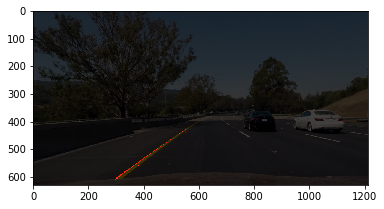

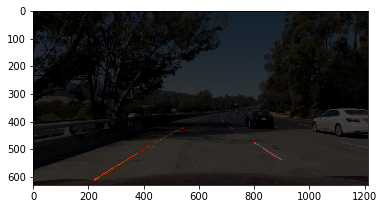

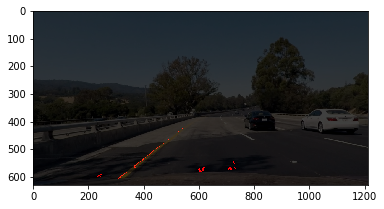

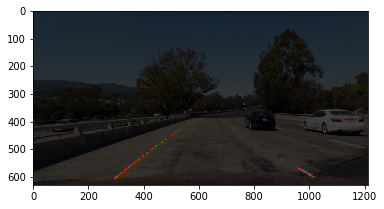

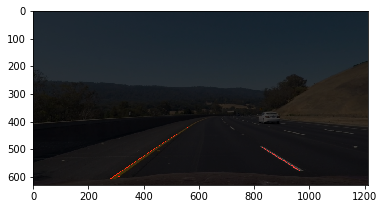

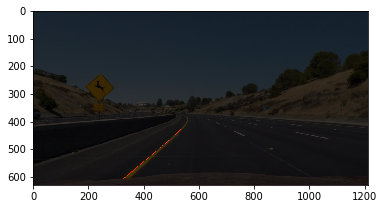

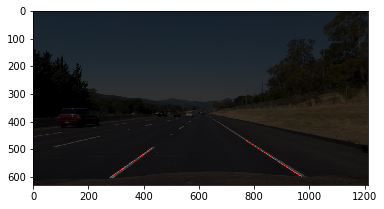

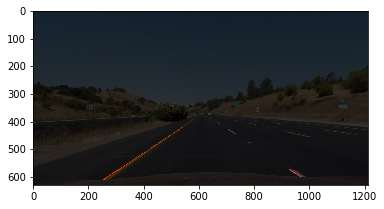

In [275]:
import os
for img in os.listdir("test_images/"):
    res = process_img(mpimg.imread("test_images/%s" % img))
    plt.imshow(res)
    plt.show()
#     plt.imsave("output_images/%s.jpg" % img[:-4], res)